## **Dataset and Model Files**

In [0]:
import os
os.mkdir('Seq2Seq')

In [0]:
from google.colab import files
files.upload() #upload kaggle.json

Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Download and process Common Voice dataset

Download and unzip (takes approx. 12 minutes)

In [0]:
!pip install -q kaggle
!mkdir /root/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mozillaorg/common-voice

!mkdir common-voice
!unzip -q common-voice.zip -d common-voice

Get required files only

In [0]:
import shutil

os.mkdir('Seq2Seq/CV')
shutil.move('common-voice/cv-valid-train/cv-valid-train', 'Seq2Seq/CV')
shutil.move('common-voice/cv-valid-test/cv-valid-test', 'Seq2Seq/CV')
shutil.move('common-voice/cv-valid-dev/cv-valid-dev', 'Seq2Seq/CV')
shutil.move('common-voice/cv-valid-train.csv', 'Seq2Seq/CV')
shutil.move('common-voice/cv-valid-test.csv', 'Seq2Seq/CV')
shutil.move('common-voice/cv-valid-dev.csv', 'Seq2Seq/CV')

shutil.rmtree('common-voice')
os.remove('common-voice.zip')

Move to deepspeech directory

In [0]:
import os
os.chdir('Seq2Seq')

Upload model files

In [0]:
from google.colab import files
files.upload()

Prepare Common Voice dataset (takes approx. 100 minutes)

In [0]:
!python3 prepare_cv.py

## **Model Training**

In [0]:
import constants as c
from cv_generator import generator
from visualization import plot_accuracy, plot_loss
from model import create_model, create_optimizer, create_loss_function

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 620, 13)]    0                                            
__________________________________________________________________________________________________
bidirectional_encoder (Bidirect multiple             69000       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 32, 30)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 200)          0           bidirectional_encoder[0][1]      
                                                                 bidirectional_encoder[0][2]  

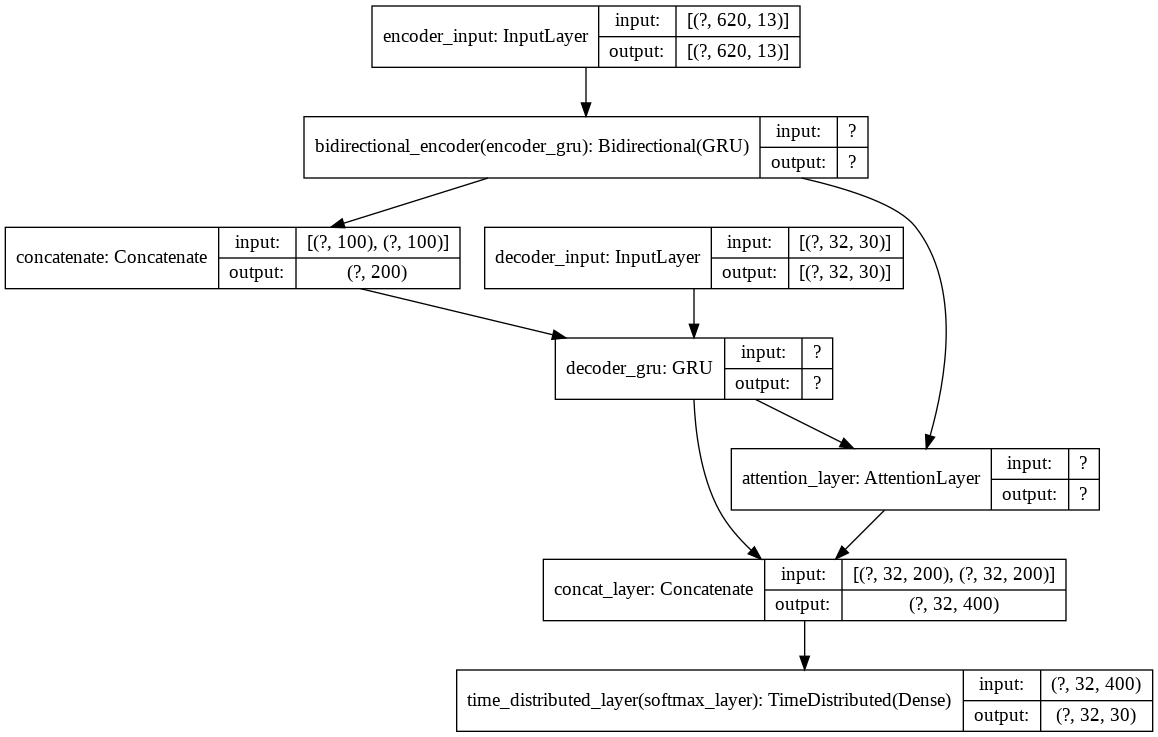

In [10]:
full_model, encoder_model, decoder_model = create_model(c.max_X_seq_len, c.max_y_seq_len)

full_model.summary()

optimizer = create_optimizer()

loss = create_loss_function()

full_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

from tensorflow.keras.utils import plot_model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)
plot_model(full_model, to_file='full_model.png', show_shapes=True)

In [0]:
import numpy as np
import pandas as pd
train = pd.read_csv(os.path.join('CV', 'cv_train.csv')).to_numpy()
steps_per_epoch = int(np.ceil(train.shape[0]/c.batch_size))
dev = pd.read_csv(os.path.join('CV', 'cv_dev.csv')).to_numpy()
validation_steps = int(np.ceil(dev.shape[0]/c.batch_size))

history = full_model.fit(
    generator(),
    steps_per_epoch=steps_per_epoch,
    validation_data=generator('dev'),
    validation_steps=validation_steps,
    epochs=100,
    initial_epoch=0
    )

Epoch 1/100
401/401 [==============================] - 324s 808ms/step - loss: 1.8582 - accuracy: 0.4648 - val_loss: 1.5017 - val_accuracy: 0.5490
Epoch 2/100
401/401 [==============================] - 320s 797ms/step - loss: 1.3691 - accuracy: 0.5921 - val_loss: 1.2824 - val_accuracy: 0.6210
Epoch 3/100
401/401 [==============================] - 322s 802ms/step - loss: 1.1332 - accuracy: 0.6661 - val_loss: 1.1081 - val_accuracy: 0.6725
Epoch 4/100
401/401 [==============================] - 319s 794ms/step - loss: 0.9135 - accuracy: 0.7328 - val_loss: 0.9259 - val_accuracy: 0.7273
Epoch 5/100
401/401 [==============================] - 320s 799ms/step - loss: 0.7420 - accuracy: 0.7843 - val_loss: 0.8176 - val_accuracy: 0.7616
Epoch 6/100
401/401 [==============================] - 318s 793ms/step - loss: 0.6130 - accuracy: 0.8225 - val_loss: 0.6824 - val_accuracy: 0.8029
Epoch 7/100
401/401 [==============================] - 318s 793ms/step - loss: 0.5183 - accuracy: 0.8498 - val_loss: 0

In [0]:
plot_accuracy(history)
plot_loss(history)

In [0]:
full_model.save_weights("full_model.h5")
encoder_model.save_weights("encoder_model.h5")
decoder_model.save_weights("decoder_model.h5")

## **Delete Me**

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import os

import constants as c
from text import encode
from features import get_features

In [0]:
data = pd.read_csv(os.path.join('CV', 'cv_all.csv')).to_numpy()

max_X = 0
max_y = 0

X_lengths = np.zeros(data.shape[0])

for i, (path, transcript) in enumerate(data):
    
    X = get_features(np.load(path + '.npy'))
    y = encode(c.start_token + transcript + c.end_token)
    
    X_lengths[i] = X.shape[0]

    if(X.shape[0] > max_X):
        max_X = X.shape[0]
    
    if(y.shape[0] > max_y):
        max_y = y.shape[0]

max_X, max_y

(620, 22)

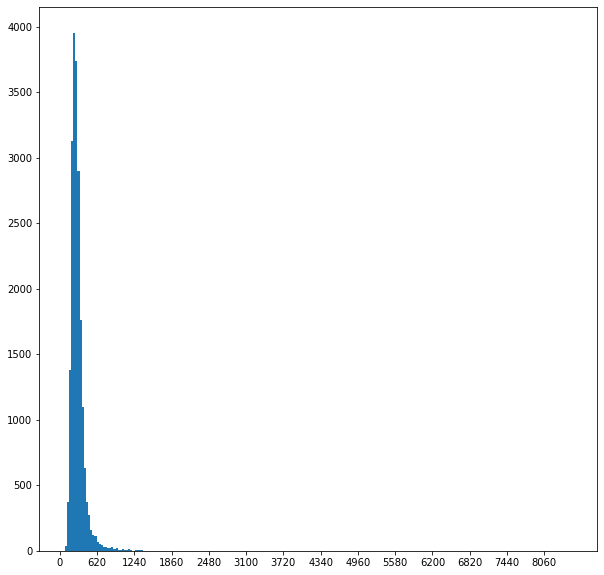

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.xticks(np.arange(0, max_X, step=620))
plt.hist(X_lengths, bins=240)
plt.show()

In [0]:
np.argmax(X_lengths)
data[7248]

array(['CV/cv-valid-train/sample-074965.mp3',
       'a boy came running towards me', 49, 3, nan, nan, nan, nan],
      dtype=object)

In [0]:
import IPython.display as ipd
import numpy as np
ipd.Audio(np.load('CV/cv-valid-train/sample-074965.mp3.npy'), rate=8000)